In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import re 
import datetime as dt

# 그래프 Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


### 예측
# Decision tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
#랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
#그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
# 정규분포 및 회귀분석 등
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
# Support Vector Machine (예측)
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor

### 분류
#평가함수 (분류)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#로지스틱 회귀분석
from statsmodels.api import Logit
# Decision tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# Support Vector Machine (분류)
from sklearn.svm import SVC
# KNN
from sklearn.neighbors import KNeighborsClassifier
#모델 평가
from sklearn.metrics import f1_score, roc_curve, auc
#XG BOOST
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

#주성분 분석
from sklearn.decomposition import PCA


#스케일링
from sklearn.preprocessing import scale, minmax_scale, robust_scale
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#선형 회귀모형
from sklearn.linear_model import LinearRegression
#변수선택법 (후진제거법)
from sklearn.feature_selection import RFE
#스케일 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

In [2]:
df= pd.read_csv('/home/pirl/Downloads/train_activity.csv', engine="python")

df.head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,75001,397380,aa,1.441844,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,1.10514,0.034006,0.0
1,1,75001,216231,aa,0.283219,2.247978,0.047085,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,-0.013963,0.0
2,1,75711,308769,aa,1.036910,2.956638,0.321821,0.166593,0.003470,1,0.245883,0.247337,0.0,0.0,0.00000,-0.001987,0.0
3,1,72230,387177,aa,0.229384,4.042102,0.099147,0.000000,0.001735,0,0.000000,0.000000,0.0,0.0,0.00000,-0.028884,0.0
4,1,34253,339862,aa,1.088405,0.596802,0.003377,0.000000,0.000000,0,0.000000,0.000000,0.0,0.0,0.00000,0.011777,0.0


In [51]:
df_label = pd.read_csv('/home/pirl/Downloads/train_label.csv', engine="python")

In [52]:
df_label.head()

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396


In [80]:
merge = pd.merge(df, df_label, on = 'acc_id', how='left')

In [6]:
df.isnull().sum()

day                  0
acc_id               0
char_id              0
server               0
playtime             0
npc_kill             0
solo_exp             0
party_exp            0
quest_exp            0
rich_monster         0
death                0
revive               0
exp_recovery         0
fishing              0
private_shop         0
game_money_change    0
enchant_count        0
dtype: int64

# 결측치는 없어요!!!

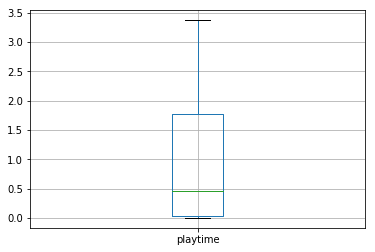

In [5]:
df[['playtime']].boxplot()

# 플레이 시간 이상치 없어요!

In [6]:
df.server.value_counts()

bd    123877
ar     83801
ay     81291
ad     66130
an     64518
at     62285
as     60162
az     59881
aa     54968
ab     54959
ag     53353
am     52618
ax     52587
al     51333
ac     51058
au     50076
ae     49959
ai     48427
av     45642
ao     44135
aq     43879
bc     40178
ap     40124
af     39915
ak     37436
bb     35837
aw     31690
ah     29956
aj     29889
bg     15317
bj     12030
bk     11646
bl     11211
bp      2987
br      2296
bn      2044
bm      1692
bo      1456
bs      1175
bi        16
Name: server, dtype: int64

# 40개 가량 서버가 존재합니다. bi 서버는 왜이렇게 적죠?

In [8]:
df[['npc_kill']].head()

,npc_kill
0,0.000000
1,2.247978
2,2.956638
3,4.042102
4,0.596802


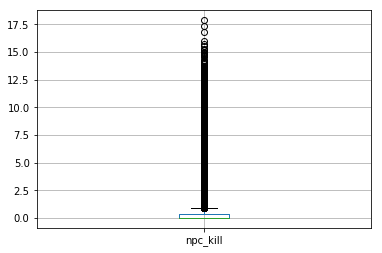

In [12]:
df[['npc_kill']].boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6684205240>]],
      dtype=object)

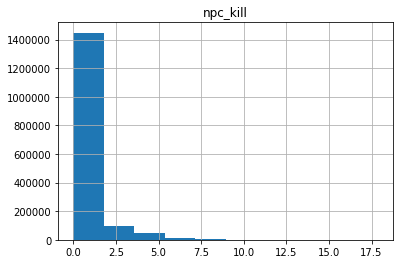

In [13]:
df[['npc_kill']].hist()

## 왜 npc 죽인횟수가 다 float으로 되어있죠?? 
## 수치형 데이터는 원본값을 표준편차로 나눈거라고 합니다!!
## 대부분 npc를 죽이진 않는데 미친놈들은 자꾸 죽입니다... 이걸 이상치라고 볼수 있을까요??? 
## 탐색적 분석 시에는 npc를 많이 죽이는 사람 위주로 그래프 분석을 해봅시다!

In [11]:
df[['solo_exp','party_exp', 'quest_exp']].head(10)

,solo_exp,party_exp,quest_exp
0,0.000000,0.000000,0.000000
1,0.047085,0.000000,0.000000
2,0.321821,0.166593,0.003470
3,0.099147,0.000000,0.001735
4,0.003377,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.047436,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


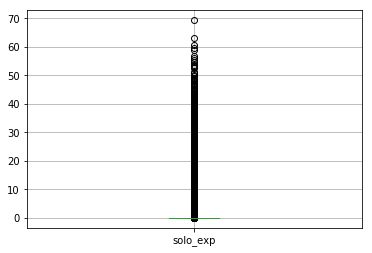

In [17]:
df[['solo_exp']].boxplot()

## ㅓㅓ? 이상하다.. 경험치 차이가 이렇게 많이 나나요????????

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6682df5f60>]],
      dtype=object)

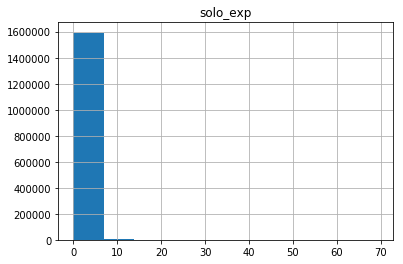

In [19]:
df[['solo_exp']].hist()

# 아에 거이 사냥을 안 한날이에요

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66825dc208>]],
      dtype=object)

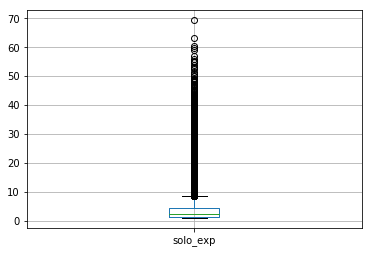

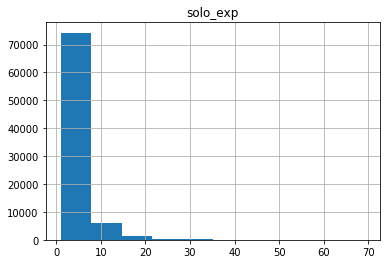

In [30]:
df[df['solo_exp']>1][['solo_exp']].boxplot()
df[df['solo_exp']>1][['solo_exp']].hist()

## 리니지는 아래와 같이 레벨에 따른 경험치 감소 시스템이 있어요!
### 65 - 69 : 원래 획득하던 경험치의 1/2
### 70 - 74 : 원래 획득하던 경험치의 1/4
### 75 - 78 : 원래 획득하던 경험치의 1/8
### 79 : 원래 획득하던 경험치의 1/16
### 80 - 81 : 원래 획득하던 경험치의 1/32
### 82 - 83 : 원래 획득하던 경험치의 1/64
### 84 - 85 : 원래 획득하던 경험치의 1/128
### 86 : 원래 획득하던 경험치의 1/256
### 87 : 원래 획득하던 경험치의 1/512

## 고인물 게임이라서 대부분 경험치를 겁나게 낮게 얻어여 ㅎㅎㅎ
## 이상치는 몇명없는 뉴비지 않을까요??
## 뉴비와 고인물을 나눠서 데이터를 분석해보죠 ㅎㅎ

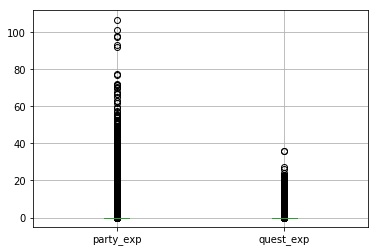

In [23]:
df[['party_exp','quest_exp']].boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f668285f3c8>,
      dtype=object)

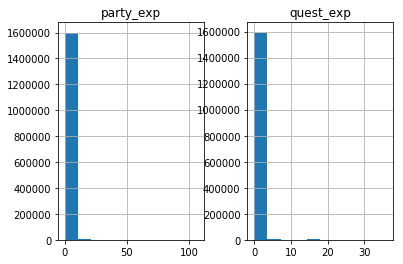

In [24]:
df[['party_exp','quest_exp']].hist()

## 솔로 뿐만아니라 퀘스트 파티 경험치도 마찬가지입니다@!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6682566f98>]],
      dtype=object)

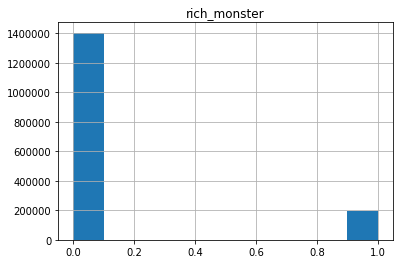

In [32]:
df[['rich_monster']].hist()

In [35]:
df[(df['playtime']==0)&(df['rich_monster']==1)]

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count


## 몬스터 타격 여부는 이상치 없어보입니다.

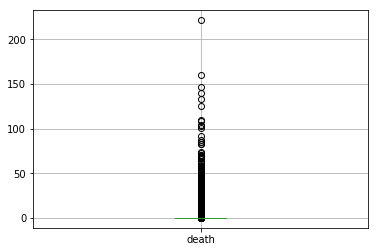

In [36]:
df[['death']].boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f668253af98>]],
      dtype=object)

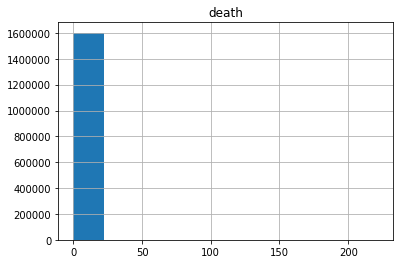

In [37]:
df[['death']].hist()

## 뒤지는 날이 그렇게 많은건 아니잖아요
## 레이드하다가 계속 뒤지는 경우도 있죠...
## 탐색적 분석시에 많이 뒤지는 놈들은 도대체 무슨짓을 했는지 알아보죠

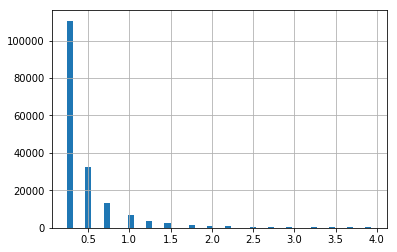

In [47]:
df[(df['death']<4)&(df['death']!=0)]['death'].hist(bins=50)

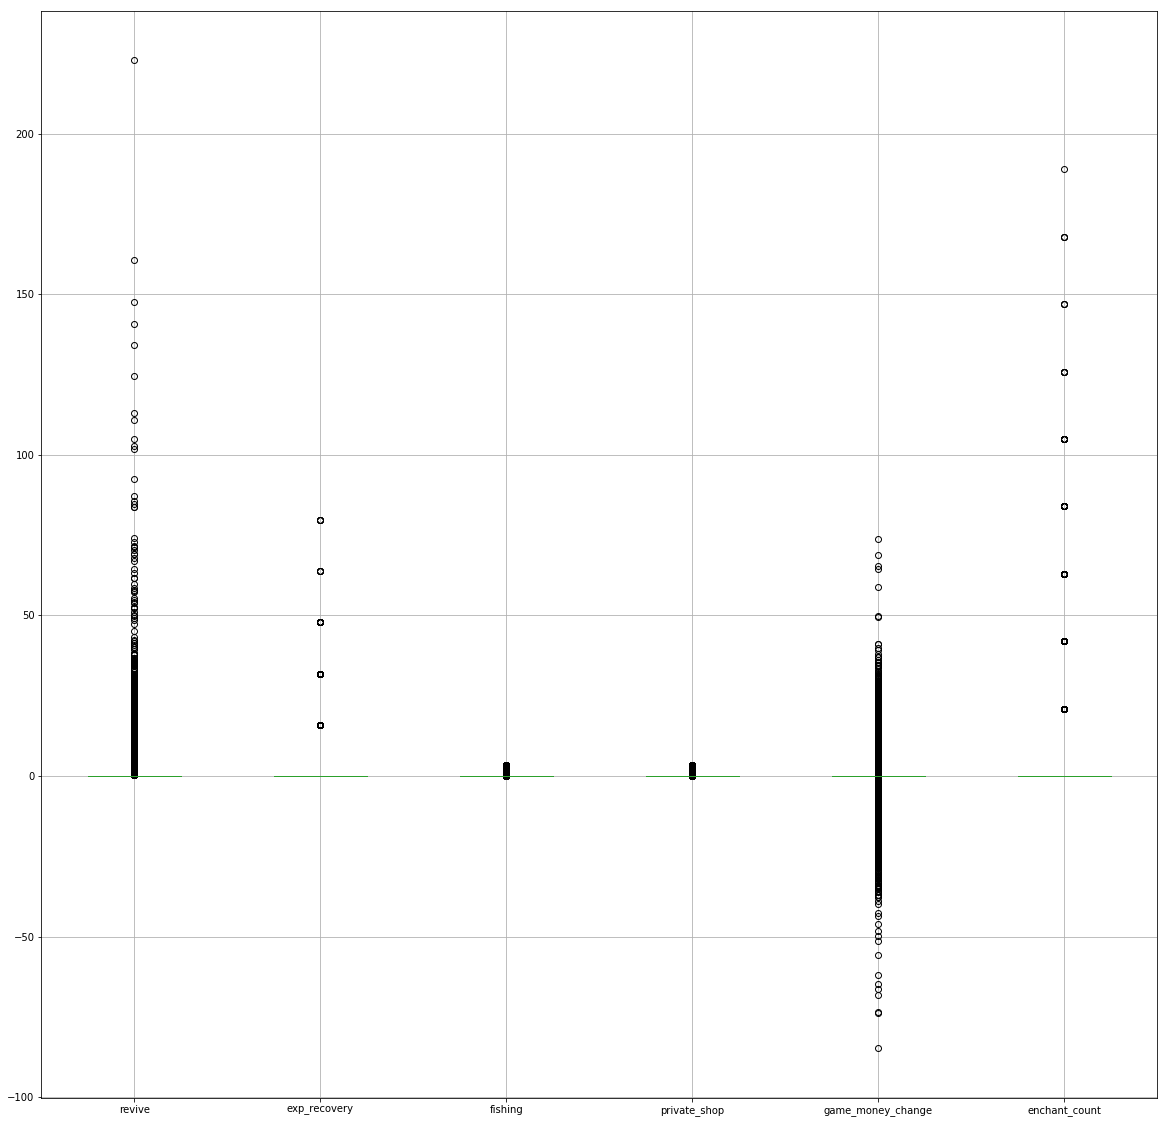

In [50]:
df.iloc[:,-6:].boxplot(figsize=(20,20))

## 나머지도 다 비슷해요~ 이상치는 제거하고 일단 진행합시다.

In [ ]:
df[(df['playtime']==0)&(df['rich_monster']==1)]

In [79]:
merge.head()

,day,acc_id,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,...,server_bi,server_bj,server_bk,server_bl,server_bm,server_bn,server_bo,server_bp,server_br,server_bs
0,1,75001,397380,1.441844,0.000000,0.000000,0.000000,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,75001,216231,0.283219,2.247978,0.047085,0.000000,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,1,75711,308769,1.036910,2.956638,0.321821,0.166593,0.003470,1,0.245883,...,0,0,0,0,0,0,0,0,0,0
3,1,72230,387177,0.229384,4.042102,0.099147,0.000000,0.001735,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1,34253,339862,1.088405,0.596802,0.003377,0.000000,0.000000,0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [98]:
temp = df.groupby(["acc_id","day"]).sum()
temp = temp.reset_index()

In [99]:
temp.head()

,acc_id,day,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,233598,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,233598,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,2,3,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,2,4,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,2,5,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [102]:
re_temp = temp.pivot(index='acc_id', columns='day')

In [104]:
re_temp = re_temp.reset_index()

In [113]:
re_temp

acc_id    char_id                                              \
day                    1          2          3          4          5   
0           2   233598.0   233598.0   233598.0   233598.0   233598.0   
1           5        NaN        NaN        NaN        NaN        NaN   
2           8  1332612.0  1081226.0  1052764.0  1260713.0  1289175.0   
3          17   135044.0   342992.0   342992.0   342992.0   519277.0   
4          20   149667.0   149667.0   149667.0   149667.0   149667.0   
5          21        NaN   109089.0   109089.0   109089.0   109089.0   
6          31   489415.0   489415.0   489415.0   346526.0   346526.0   
7          38   225966.0   202491.0   202491.0   225966.0   134994.0   
8          41        NaN        NaN        NaN        NaN        NaN   
9          43   556612.0   388134.0   388134.0   388134.0   388134.0   
10         50    78995.0    78995.0    78995.0    78995.0        NaN   
11         53    60446.0    60446.0    60446.0    60446.0    60446.0   
12         54        NaN        NaN        NaN        NaN   317400.0   
13         59   394351.0   394351.0   394351.0   394351.0   394351.0   
14         62   438510.0   438510.0   654355.0   463844.0   438510.0   
15         63        NaN        NaN        NaN        NaN        NaN   
16         65   373097.0   489700.0   760217.0   760217.0   657637.0   
17         66   127862.0   127862.0   127862.0   127862.0   143976.0   
18         67   267831.0   535662.0   803493.0   803493.0   803493.0   
19         69  1046150.0   420508.0   975682.0  1467110.0   350040.0   
20         75   138437.0   138437.0        NaN   138437.0   138437.0   
21         76   280717.0   280717.0   280717.0   280717.0   280717.0   
22         77    22622.0    22622.0    22622.0    22622.0    22622.0   
23         79   679040.0   679040.0   679040.0   679040.0   679040.0   
24         81   297398.0   297398.0   297398.0   297398.0   297398.0   
25         86    29793.0    29793.0    29793.0    29793.0    29793.0   
26         91   320252.0   320252.0   320252.0   320252.0   320252.0   
27         92   219750.0   219750.0   219750.0   219750.0   219750.0   
28         97   120776.0   120776.0   120776.0   120776.0   120776.0   
29         98   205300.0   278871.0   623869.0   550298.0   278871.0   
...       ...        ...        ...        ...        ...        ...   
39970  130383   308876.0   308876.0   308876.0   308876.0   308876.0   
39971  130384        NaN        NaN        NaN        NaN        NaN   
39972  130386    53436.0   124303.0    53436.0    53436.0    53436.0   
39973  130390   730085.0   730085.0   730085.0   730085.0   730085.0   
39974  130391   613800.0   613800.0   246355.0   613800.0   461913.0   
39975  130392   312455.0   312455.0   514627.0   312455.0   312455.0   
39976  130398   992234.0   992234.0   685998.0   601515.0   623742.0   
39977  130401   674128.0   839166.0   839166.0   839166.0   559444.0   
39978  130403   207225.0   207225.0   207225.0   207225.0   207225.0   
39979  130405   848540.0   561525.0   816746.0   504180.0  1949854.0   
39980  130408   237182.0   237182.0   237182.0   237182.0   237182.0   
39981  130411        NaN        NaN   734012.0  1068610.0        NaN   
39982  130413   360163.0   360163.0   360163.0   360163.0   360163.0   
39983  130414   190244.0   190244.0   190244.0   190244.0        NaN   
39984  130415   560779.0   166719.0   166719.0   166719.0   560779.0   
39985  130416   105415.0   105415.0   105415.0   105415.0   105415.0   
39986  130420   215839.0        NaN   215839.0        NaN   215839.0   
39987  130433   114398.0   402747.0   114398.0   114398.0   114398.0   
39988  130434   325200.0   325200.0   325200.0   162600.0   162600.0   
39989  130445    58793.0    58793.0    58793.0    58793.0    58793.0   
39990  130447   349960.0   174980.0   174980.0   174980.0   174980.0   
39991  130449   663761.0   663761.0   425366.0   736397.0   432448.0   
39992  130459    22875.0    22875.0    22875.0 

In [106]:
test = pd.merge(re_temp, df_label, on = "acc_id", how = 'left')

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [115]:
df_label

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396
5,3277,50,0.058863
6,118874,64,0.030777
7,7678,5,0.000000
8,124997,46,0.009187
9,116489,23,0.000000


In [114]:
test

,acc_id,"(acc_id, )","(char_id, 1)","(char_id, 2)","(char_id, 3)","(char_id, 4)","(char_id, 5)","(char_id, 6)","(char_id, 7)","(char_id, 8)",...,"(enchant_count, 21)","(enchant_count, 22)","(enchant_count, 23)","(enchant_count, 24)","(enchant_count, 25)","(enchant_count, 26)","(enchant_count, 27)","(enchant_count, 28)",survival_time,amount_spent
0,2,2,233598.0,233598.0,233598.0,233598.0,233598.0,233598.0,233598.0,233598.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.000000
1,5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60,0.000000
2,8,8,1332612.0,1081226.0,1052764.0,1260713.0,1289175.0,1124663.0,1332612.0,426968.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.020310
3,17,17,135044.0,342992.0,342992.0,342992.0,519277.0,342992.0,135044.0,342992.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.070642
4,20,20,149667.0,149667.0,149667.0,149667.0,149667.0,149667.0,149667.0,149667.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.052137
5,21,21,0.0,109089.0,109089.0,109089.0,109089.0,343267.0,109089.0,109089.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.184267
6,31,31,489415.0,489415.0,489415.0,346526.0,346526.0,346526.0,489415.0,346526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,0.051316
7,38,38,225966.0,202491.0,202491.0,225966.0,134994.0,158469.0,225966.0,225966.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.517168
8,41,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.000000
9,43,43,556612.0,388134.0,388134.0,388134.0,388134.0,388134.0,388134.0,388134.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.356197


In [109]:
test = test.fillna(0)

In [110]:
#종속변수, 독립변수 분할
df_raw_y = test["survival_time"]
df_raw_x = test.drop(["survival_time","amount_spent"],axis=1,inplace=False)


#train, test 1차 분할
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y, test_size=0.3,random_state=1234)
print(df_train_x.shape)
print(df_test_x.shape)
print(df_train_y.shape)
print(df_test_y.shape)

(28000, 394)
(12000, 394)
(28000,)
(12000,)


In [111]:
tree_uncustumized = RandomForestClassifier(random_state=1234)
tree_uncustumized.fit(df_train_x,df_train_y)

print(tree_uncustumized.score(df_train_x,df_train_y))

print(tree_uncustumized.score(df_val_x,df_val_y))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9904285714285714


NameError: name 'df_val_x' is not defined

In [112]:
print(tree_uncustumized.score(df_test_x,df_test_y))

0.608
